# <sup>27</sup>Al training process with DFT computed Al structures

In [2]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from pymatgen.analysis.local_env import CrystalNN
import copy
from pymatgen.io import ase
import matplotlib.pyplot as plt
from src.Utility import struc_to_cif
import seaborn as sns
from src.local_features import NMR_local
from pymatgen.core.structure import Structure as ST

## 1. Get structures and NMR raw tensors.
------------------------------------------------------------

In [2]:
with open("data/Alnmr.json", "r") as file:
    data = json.load(file)
    print("length of file is {}".format(len(data)))

length of file is 3479


In [3]:
# test if there's any structure dosen't contain the target atom ('Al') and does not contain a structure section
problem_compound = []
for compound in data:
    if "structure" not in compound.keys():
        problem_compound.append(compound)
        continue
    sites = []
    for site in compound["structure"]["sites"]:
        sites.append(site["label"])
    if "Al" not in sites:
        problem_compound.append(compound)
print("num of problem compound:", len(problem_compound))

for compound in problem_compound:
    data.remove(compound)
print("len of none problematic data:", len(data))

num of problem compound: 8
len of none problematic data: 3471


In [4]:
# get rid of the redundances
for i in range(len(data)):
    string = json.dumps(data[i], sort_keys=True)
    data[i] = string
data = list(set(data))

for i in range(len(data)):
    dictionary = json.loads(data[i])
    data[i] = dictionary
print("length of file without redundancy is {}".format(len(data)))

length of file without redundancy is 3022


In [5]:
# get the structure_tensors obj
from src.structure_tensors_gen import get_structure_tensors

structure_tensors = get_structure_tensors(data)
print("length of structure_tensors:", len(structure_tensors))

  8%|▊         | 235/3022 [00:08<00:57, 48.50it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/nmr.py:201: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((V[1] - V[0]) / V[2])
100%|██████████| 3022/3022 [00:59<00:00, 51.01it/s] 

length of structure_tensors: 3022


In [6]:
# Here's what a structure_tensors obj looks like:
structure_tensors[0]

{'structure': Structure Summary
 Lattice
     abc : 7.047900796455424 7.085746 9.810307074374023
  angles : 90.0 90.17366099134406 90.0
  volume : 489.9209029388083
       A : 7.047871 0.0 -0.020494
       B : 0.0 7.085746 0.0
       C : -0.001208 0.0 9.810307
 PeriodicSite: K (3.2738, 5.3143, 3.5059) [0.4646, 0.7500, 0.3583]
 PeriodicSite: K (0.1013, 5.3143, 1.0338) [0.0144, 0.7500, 0.1054]
 PeriodicSite: K (3.7729, 1.7714, 6.2839) [0.5354, 0.2500, 0.6417]
 PeriodicSite: K (6.9454, 1.7714, 8.7561) [0.9856, 0.2500, 0.8946]
 PeriodicSite: Na (1.4730, 1.7714, 2.3582) [0.2090, 0.2500, 0.2408]
 PeriodicSite: Na (5.5737, 5.3143, 7.4316) [0.7910, 0.7500, 0.7592]
 PeriodicSite: Al (3.5239, 0.0000, -0.0102) [0.5000, 0.0000, 0.0000]
 PeriodicSite: Al (2.1687, 5.3143, 7.0457) [0.3078, 0.7500, 0.7188]
 PeriodicSite: Al (4.8779, 1.7714, 2.7441) [0.6922, 0.2500, 0.2812]
 PeriodicSite: Al (-0.0006, 3.5429, 4.9052) [0.0000, 0.5000, 0.5000]
 PeriodicSite: Al (3.5239, 3.5429, -0.0102) [0.5000, 0.5000, 

## 2. Data cleaning and pre-training preparations 
---------------------------------------------------------------

In [7]:
from src.structure_tensors_modifier import get_n_coord_tensors, append_coord_num, add_oxi_state_by_guess
# Add oxidation state for each structures in structure_tensors obj. Might take a long time based on the structure.
structure_tensors = add_oxi_state_by_guess(structure_tensors)
# Filter structure based on coordination number and append coord num info to "tensors".
structure_tensors_filtered = get_n_coord_tensors(structure_tensors, coord=[4, 5, 6])
structure_tensors_filtered = append_coord_num(structure_tensors_filtered)
len(structure_tensors_filtered)

Add oxidation state by guess.


100%|██████████| 3022/3022 [2:34:35<00:00,  3.07s/it]


Filter structures based coordination number.


  1%|          | 18/3022 [00:03<07:26,  6.73it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 3022/3022 [05:36<00:00,  8.99it/s]


num of structures with [4, 5, 6] coords only: 1862
Append coordination numbers to tensor list.


100%|██████████| 1862/1862 [03:41<00:00,  8.41it/s]


1862

In [8]:
# Add chemical environment info to "Tensor" list. Might take a long time based on the structure. 
from src.structure_tensors_modifier import append_ce
structure_tensors_filtered = append_ce(structure_tensors_filtered)

Append ChemEnv info to tensor list.

If you use the ChemEnv tool for your research, please consider citing the following reference(s) :
David Waroquiers, Xavier Gonze, Gian-Marco Rignanese, Cathrin Welker-Nieuwoudt, Frank Rosowski,
Michael Goebel, Stephan Schenk, Peter Degelmann, Rute Andre, Robert Glaum, and Geoffroy Hautier,
"Statistical analysis of coordination environments in oxides",
Chem. Mater., 2017, 29 (19), pp 8346-8360,
DOI: 10.1021/acs.chemmater.7b02766



100%|██████████| 1862/1862 [28:12<00:00,  1.10it/s]


In [9]:
# Filter structures based on local chemenv. Here we select T:4 T:5 O:6 sites
from src.structure_tensors_modifier import filter_ce
chemenv_filter = filter_ce(structure_tensors_filtered)
# number of outliers
print("number of outliers:",len(chemenv_filter["outliers"]))

Filter structure_tensors based on ChemEnv info.


100%|██████████| 1862/1862 [00:00<00:00, 240175.72it/s]

num of structures with chemenv ['T:4', 'T:5', 'O:6'] only: 1681
number of outliers: 181


In [10]:
# Save the processed data for later direct use
processed_data = copy.deepcopy(chemenv_filter["filtered"])
for data in processed_data:
    data['structure'] = data['structure'].as_dict()
dir_ = "./data/"
filename = "processed_data_0.5.json"
with open(dir_+filename,'w') as outfile:
    json.dump(processed_data, outfile)

## 3. Visualization
----------------------------------------------

In [3]:
# Read processed data and continue
with open("./data/processed_data_0.5.json", "r") as file:
    data_reload = json.load(file)
for data in data_reload:
    data['structure'] = ST.from_dict(data['structure'])
print("length of data set is:", len(data_reload))

length of data set is: 1681


In [4]:
# Calculate the features.
from src.Utility import features_gen
nmr_struc_data = features_gen(data_reload)
nmr_struc_data = nmr_struc_data.drop(['longitudinal_strain','shear_strain'],axis=1)
nmr_struc_data.head()

  0%|          | 0/1681 [00:00<?, ?it/s]/mnt/c/Users/wusha/Documents/GitHub/27Al_CQ_prediction/src/local_features.py:626: RuntimeWarning: divide by zero encountered in reciprocal
  dis_matrix_rev = np.reciprocal(distance_matrix(coords_all,coords_all))
  1%|          | 12/1681 [00:01<04:05,  6.79it/s]/home/he/anaconda3/envs/27al_ml/lib/python3.8/site-packages/pymatgen/analysis/local_env.py:3938: UserWarning: CrystalNN: cannot locate an appropriate radius, covalent or atomic radii will be used, this can lead to non-optimal results.
  warnings.warn(
100%|██████████| 1681/1681 [04:34<00:00,  6.13it/s]

There are 0 structures returns error. Their index are []
error_messages:
 []


,diso,etaQ,CQ,max_ce,fbl_average,fbl_std,fbl_max,fbl_min,fba_average,fba_std,...,110,111,112,113,114,115,116,117,118,119
6,208.923473,0.170496,11.000916,O:6,1.833601,0.043782,1.870261,1.778013,108.000000,37.280245,...,7.808198e+06,7437.594732,5388.062554,5206.268446,5178.447623,877.773945,226.216965,218.584367,217.416314,154.426473
7,209.644085,0.037950,12.465360,O:6,1.833714,0.051692,1.872387,1.757785,107.323751,35.950328,...,7.808204e+06,7451.127696,5371.888651,5214.429324,5177.131647,877.997702,225.537906,218.935873,217.750875,154.730000
8,209.636354,0.037931,12.465249,O:6,1.833714,0.051692,1.872387,1.757785,107.323751,35.950328,...,7.808204e+06,7451.127696,5371.888651,5214.429324,5177.131647,877.997702,225.537906,218.935873,217.750875,154.730000
9,208.133842,0.141137,10.904085,O:6,1.835468,0.042926,1.868216,1.780377,108.000000,37.268337,...,7.808171e+06,7449.224422,5331.057288,5267.095270,5180.760458,877.127081,223.823607,221.138172,217.513418,154.602508
10,208.927483,0.170496,11.000916,O:6,1.833601,0.043782,1.870261,1.778013,108.000000,37.280245,...,7.808198e+06,7437.594732,5388.062554,5206.268446,5178.447623,877.773945,226.216965,218.584367,217.416314,154.426473


number of sites with T:4 is:  4696 
 number of sites with T:5 is:  202 
 number of sites with O:6 is:  3183 



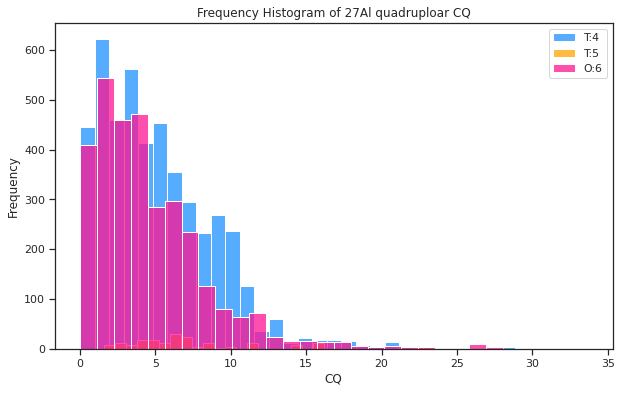

In [68]:
#plot hist of 27Al CQ colored based on type of chemical env.
x1 = nmr_struc_data.loc[nmr_struc_data.max_ce=='T:4', 'CQ']
x2 = nmr_struc_data.loc[nmr_struc_data.max_ce=='T:5', 'CQ']
x3 = nmr_struc_data.loc[nmr_struc_data.max_ce=='O:6', 'CQ']

print("number of sites with T:4 is: ", len(x1),'\n',
      "number of sites with T:5 is: ", len(x2),'\n',
      "number of sites with O:6 is: ", len(x3),'\n')

fig, ax = plt.subplots(figsize=[10, 6])
kwargs = dict(ax=ax,bins=30)

sns.histplot(x1, color="dodgerblue", label="T:4", **kwargs)
sns.histplot(x2, color="orange", label="T:5", **kwargs)
sns.histplot(x3, color="deeppink", label="O:6", **kwargs)
plt.gca().set(title='Frequency Histogram of 27Al quadruploar CQ', ylabel='Frequency')
plt.legend()

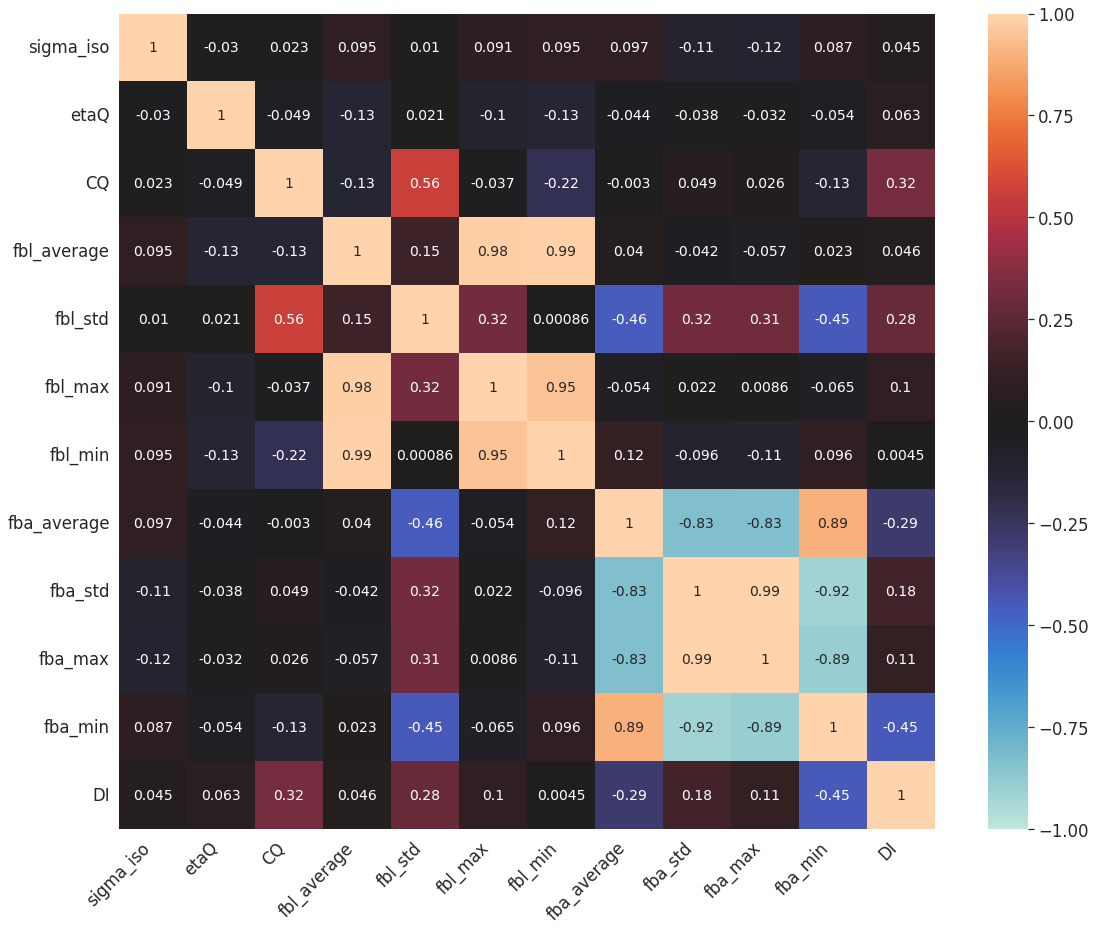

In [12]:
# heat map of structural features
corr = nmr_struc_data.rename(columns={'diso':'sigma_iso'}).loc[:, :"DI"].corr()

plt.figure(figsize=[19, 15])
heat_map = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    #     cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True,
    annot_kws={"size": 14},
)
heat_map.set_xticklabels(
    heat_map.get_xticklabels(), rotation=45, horizontalalignment="right"
)
sns.set(font_scale=1.5)
plt.savefig("./figures/27Al_color_map.png", format="png", bbox_inches="tight")
plt.show()

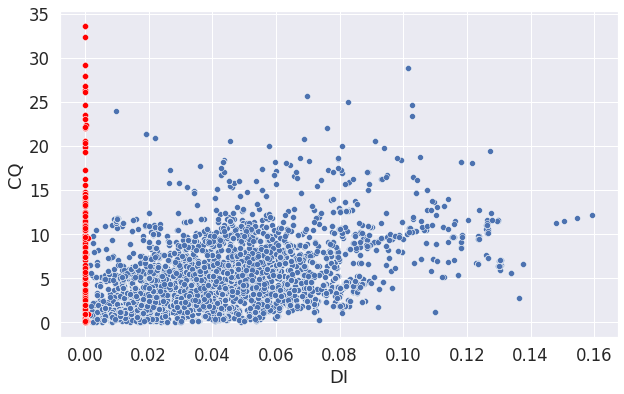

In [13]:
# Noticed that the distrotion index can not correctly represent some of the local geometries. (red labeled ones)
red_labels = nmr_struc_data[
    (nmr_struc_data["DI"] < 0.001) & (nmr_struc_data["CQ"] > 0)
]

fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(data=nmr_struc_data, x='DI', y='CQ', ax=ax)
sns.scatterplot(data=red_labels, x='DI', y='CQ', ax=ax, color="red")
plt.show()

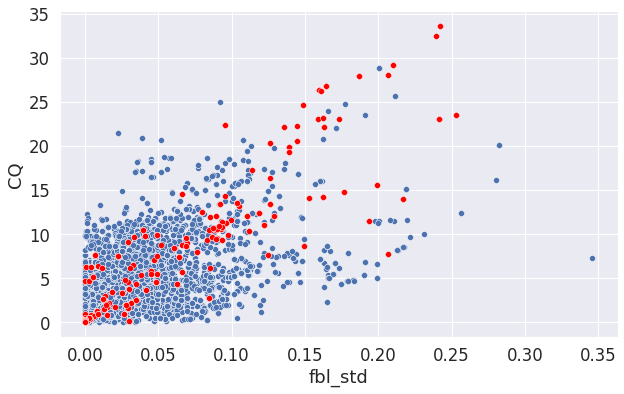

In [14]:
# And these unrepresented geometries are nicely represented by the standard deviation of first order bond length. 
fig, ax = plt.subplots(figsize=[10, 6])
sns.scatterplot(data = nmr_struc_data, x='fbl_std', y='CQ',ax=ax)
sns.scatterplot(data = red_labels, x='fbl_std', y='CQ', ax=ax, color="red")
plt.show()

## 4. Model training 
------------------------------------------------
1. Random forest
2. GBDT (XGboost)

In [64]:
# split y and x
y = nmr_struc_data[["CQ","max_ce"]]
x = nmr_struc_data.loc[:, 'max_ce':]

# train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=6
)

print(f"Size of train set: {len(X_train)}\nSize of test set: {len(X_test)}")

Size of train set: 6464
Size of test set: 1617


### Random forest

In [65]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10,min_samples_split=4,min_samples_leaf=2)

param = {"n_estimators": randint(low=100, high=500), 
         "max_depth": uniform(10, 200),
         "max_features": ['auto', 'sqrt','log2']
         }

grid_rf = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)
grid_rf.fit(X_train.drop(["max_ce"],axis=1), y_train['CQ'])

# summarize the results of the grid search
train_r2 = np.sort(grid_rf.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid_rf.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid_rf.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid_rf.best_estimator_)

training score: R2 = 0.9540127727598673, RMSE = 0.8745328511002033, MAE = 0.37555231193623606
RandomForestRegressor(max_depth=204.6662601960592, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=418, random_state=10)
CPU times: user 1min 42s, sys: 93.8 ms, total: 1min 42s
Wall time: 7min 5s


<AxesSubplot:>

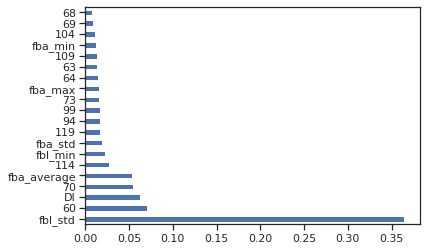

In [66]:
#plot feature importance 
feat_importances = pd.Series(grid_rf.best_estimator_.feature_importances_, index=X_train.drop(["max_ce"],axis=1).columns)
feat_importances.nlargest(20).plot(kind='barh')

test scores: R2 = 0.9676222400514183, RMSE = 0.7041890245116212, MAE = 0.2946099556042805
date and time: 02-11-2021_04-04-43


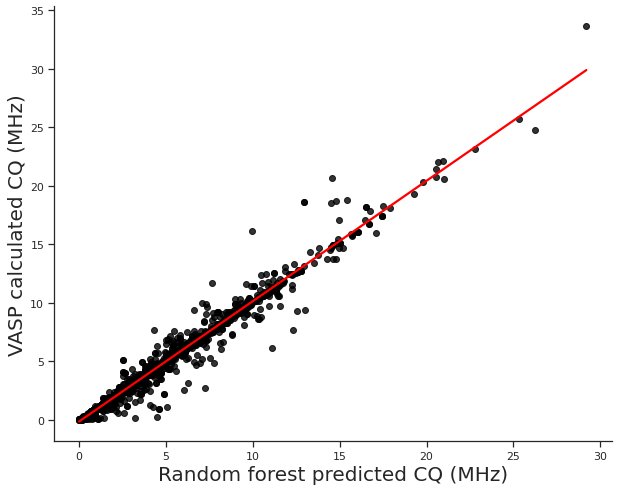

CPU times: user 453 ms, sys: 125 ms, total: 578 ms
Wall time: 316 ms


In [42]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

y_rf = grid_rf.predict(X_test.drop("max_ce",axis=1))

test_r2 = r2_score(y_test["CQ"], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['CQ'], y_rf))
test_MAE = mean_absolute_error(y_test['CQ'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['CQ']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ (MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
# plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()

t4 test scores: R2 = 0.9743715681164313, RMSE = 0.6097561986880616, MAE = 0.25370055950963294
t5 test scores: R2 = 0.8971491289219848, RMSE = 1.264048641691902, MAE = 0.5805191474728768
o6 test scores: R2 = 0.9628205927241774, RMSE = 0.7749313676315689, MAE = 0.3320551028491321
CPU times: user 109 ms, sys: 15.6 ms, total: 125 ms
Wall time: 182 ms


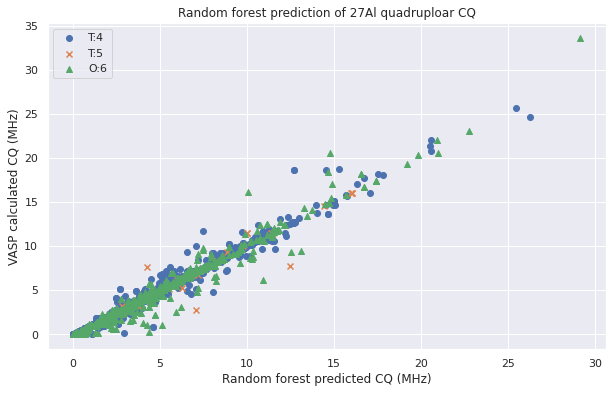

In [57]:
%%time
# # Predict test set splited by chemical environment.
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

x_test_dict = dict(
    t4 = X_test.loc[X_test.max_ce=='T:4',:],
    t5 = X_test.loc[X_test.max_ce=='T:5',:],
    o6 = X_test.loc[X_test.max_ce=='O:6',:])

y_test_dict = dict(
    t4 = y_test.loc[y_test.max_ce=='T:4',:],
    t5 = y_test.loc[y_test.max_ce=='T:5',:],
    o6 = y_test.loc[y_test.max_ce=='O:6',:])

y_rf_dict ={}
for k, v in x_test_dict.items():
    y_rf = grid.predict(v.drop("max_ce",axis=1))
    y_rf_dict[k]=y_rf
    test_r2 = r2_score(y_test_dict[k]["CQ"], y_rf)
    test_RMSE = math.sqrt(mean_squared_error(y_test_dict[k]["CQ"], y_rf))
    test_MAE = mean_absolute_error(y_test_dict[k]["CQ"], y_rf)
    print(f"{k} test scores: R2 = {test_r2}, RMSE = {test_RMSE}, MAE = {test_MAE}")

fig, ax = plt.subplots(figsize=[10, 6])
# kwargs = dict(ax=ax,bins=30)

plt.scatter(x=y_rf_dict['t4'],y=y_test_dict['t4']['CQ'], marker='o', label="T:4")
plt.scatter(x=y_rf_dict['t5'],y=y_test_dict['t5']['CQ'], marker='x', label="T:5")
plt.scatter(x=y_rf_dict['o6'],y=y_test_dict['o6']['CQ'], marker='^', label="O:6")
plt.gca().set(title='Random forest prediction of 27Al quadruploar CQ', 
              xlabel="Random forest predicted CQ (MHz)",ylabel="VASP calculated CQ (MHz)")

plt.legend()



### GBDT (XGboost)

In [32]:
import xgboost
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

model = xgboost.XGBRegressor(tree_method = "hist")

param = {"learning_rate":uniform(0, 1),
         "max_depth":randint(3,20),
         "min_child_weight": randint(1,10),
         "eta":uniform(0.01,0.2),
         "gamma": uniform(0,1),
         'reg_alpha': [1e-5,1e-2,0.1,1,100],
         'subsample':uniform(0,1),
         'colsample_bytree':uniform(0,1)
         }
grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=50,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
)
grid.fit(X_train.drop(["max_ce"],axis=1), y_train['CQ'])

# summarize the results of the grid search
train_r2 = np.sort(grid.cv_results_["mean_test_r2"])[-1]
train_RMSE = math.sqrt(
    -np.sort(grid.cv_results_["mean_test_neg_mean_squared_error"])[-1]
)
train_MAE = -np.sort(grid.cv_results_["mean_test_neg_mean_absolute_error"])[-1]

print(
    "training score: R2 = {}, RMSE = {}, MAE = {}".format(
        train_r2, train_RMSE, train_MAE
    )
)
print(grid.best_estimator_)

training score: R2 = 0.9674038382697517, RMSE = 0.7390862037170285, MAE = 0.2647769658879384
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5690646421416687,
             enable_categorical=False, eta=0.10346306005776441,
             gamma=0.4119120432417658, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.20438512745328086,
             max_delta_step=0, max_depth=10, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, subsample=0.6031945240843097,
             tree_method='hist', validate_parameters=1, verbosity=None)


test scores: R2 = 0.9754497086685429, RMSE = 0.613188748791737, MAE = 0.27885418777869253
date and time: 02-11-2021_03-50-43


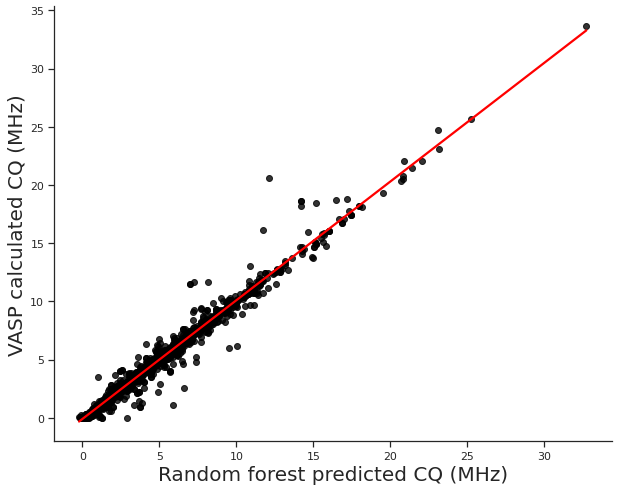

CPU times: user 781 ms, sys: 109 ms, total: 891 ms
Wall time: 218 ms


In [33]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns

sns.set()
import matplotlib.pyplot as plt
from datetime import datetime

y_rf = grid.predict(X_test.drop("max_ce",axis=1))

test_r2 = r2_score(y_test["CQ"], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['CQ'], y_rf))
test_MAE = mean_absolute_error(y_test['CQ'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['CQ']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ (MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
# plt.savefig('./figures/27Al_RF_testSet_{}.png'.format(dt_string))
plt.show()

In [44]:
# save the model to disk
import pickle
dir_ = "./models/best/"
filename = 'Best_model_10132021.sav'
pickle.dump(grid, open(dir_+filename, 'wb'))